In [1286]:
import math

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

$$
S(x) = \frac{e^x}{e^x + 1}
$$

# Construindo e treinando uma rede neural

In [1287]:
import random

class Neuronio:
    def __init__(self, num_dados_entrada,ativacao = 1):
        self.vies = Valor(random.uniform(-1, 1))
        self.ativacao = ativacao
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida*self.ativacao       
    
    def parametros(self):
        return self.pesos + [self.vies]

In [1288]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

In [1289]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

In [1290]:
from numpy import e

In [1291]:
e**(709)

8.218407461554662e+307

In [1292]:
import seaborn as sns
df = sns.load_dataset('diamonds')
df= df.reindex(columns=['carat','price','depth','x'	,'y','z'])
df = df.dropna()
df = df.reset_index()
df = df.head(100)
x = []
y_true = []
for i in range(len(df['carat'])):
    
    xn =[float(df['x'][i]),float(df['y'][i]),float(df['z'][i])]
    yn =float(df['price'][i])
    xn = x.append(xn)
    yn = y_true.append(yn)

In [1293]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
  [4.0, 1.0, -1.0],
  [2.0, 1.5, -1.0],
  [1.0, 1.5, -1.0],
  [3.0, 1.5, -1.0],
]

y_true = [1, 0, 0.2, 0.5,3,2,1.4,2]

In [1294]:
NUM_DADOS_DE_ENTRADA = len(x[0])  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [100, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [1295]:
def rede_neural(rede,num_epocas, taxa_de_aprendizado,
                x, y_true, neuronios, drop_out = False,taxa_drop = 0.5):
    dropados = 0

    numero_de_neuronios = 102

    n_dropas = int(numero_de_neuronios*taxa_drop)
    n_mantem = numero_de_neuronios*(num_epocas)-n_dropas
    lista_drops = [0]*n_dropas
    lista_mantem = [1]*n_mantem
    lista_drop = []  
    lista_drop.extend(lista_mantem)
    lista_drop.extend(lista_drops)                  
    random.shuffle(lista_drop)
    n = int(0)
    count = 0
    
                    
    for epoca in range(num_epocas):
        print(n)
        if drop_out:
            drop = taxa_drop/num_epocas
            if epoca+1 == num_epocas:
                for i in range(len(rede.camadas)):
                    for j in range(len(rede.camadas[i].neuronios)):
                        if rede.camadas[i].neuronios[j].ativacao == 0:
                            rede.camadas[i].neuronios[j].ativacao = 1
            if epoca+1 != num_epocas:
                for i in range(len(rede.camadas)):
                    for j in range(len(rede.camadas[i].neuronios)):
                        if rede.camadas[i].neuronios[j].ativacao == 1:
                            atv = int(lista_drop[n])
                            
                        
                            #atv = random.choices([1,0],[1-drop,drop])[0]
                            rede.camadas[i].neuronios[j].ativacao = atv
                            
                            if atv == 0:
                                dropados+=1
                        n+=1 
                        count+=1               
        y_pred = []
        for exemplo in x:
            previsao = rede(exemplo)
            y_pred.append(previsao)

        # loss
        erros = []
        for yt, yp in zip(y_true, y_pred):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros.append(erro_quadratico)        
        loss = sum(erros)

        # zero grad
        for p in rede.parametros():
            p.grad = 0

        # backpropagation
        loss.propagar_tudo()

        # atualiza parâmetros
        for p in rede.parametros():
            p.data = p.data - p.grad * taxa_de_aprendizado

        # mostra resultado (opcional)
        #print("                                                          ",end='\r')
        print(epoca,len(lista_drop),n_mantem, numero_de_neuronios,n_dropas," ", loss.data,f'dropados = {dropados} , {count}')
        rede_treinada = rede
        
    return y_pred,rede_treinada,lista_drop

In [1296]:
#y_true,y_pred

In [1297]:
y_pred,rede, lista = rede_neural(minha_mlp,5,0.8,x,y_true,CAMADAS_OCULTAS,drop_out=True,)
vals_y = []
for i in y_pred:
    vals_y.append(i.data)

0
0 510 459 102 51   12.493271208982456 dropados = 7 , 103
103
1 510 459 102 51   8.388292144697985 dropados = 15 , 206
206
2 510 459 102 51   8.319364543341663 dropados = 30 , 309
309
3 510 459 102 51   20.25 dropados = 36 , 412
412
4 510 459 102 51   8.25004787256775 dropados = 36 , 412


In [1298]:
type(103+1)

int

In [1299]:
len(lista)

510

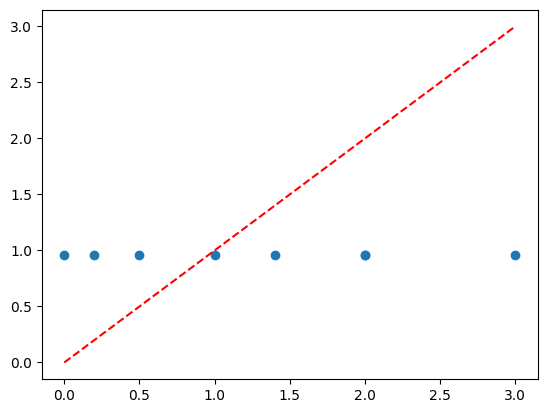

In [1300]:
import matplotlib.pyplot as plt

plt.scatter(y_true,vals_y)
_ = plt.plot([min(y_true), max(y_true)],[min(y_true), max(y_true)],color = 'red',linestyle = '--')
